# This file contains comparision of LSTM with Implicit models with following datasets.

# 1) Crude Oil
# 2) Synthetic data

# Crude oil data



Using device: cuda


[*********************100%***********************]  1 of 1 completed


Preprocessing data...
Training shape: torch.Size([2422, 60]), Testing shape: torch.Size([1038, 60])
Initializing model...
Model size: 5024 parameters
Training model...
Epoch 0, Loss: 0.019420
Epoch 20, Loss: 0.000544
Epoch 40, Loss: 0.000372
Epoch 60, Loss: 0.000373
Epoch 80, Loss: 0.000364
Evaluating model...

Model Performance:
R² Score: 0.9821
MAPE: 0.0291

Plotting results...


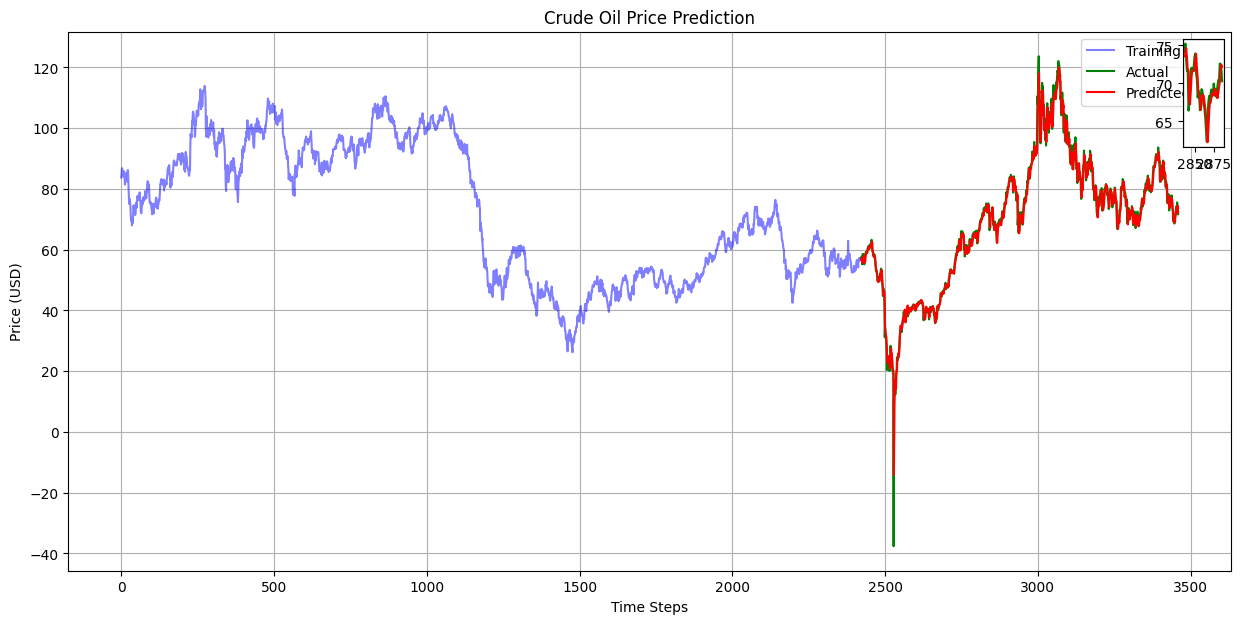

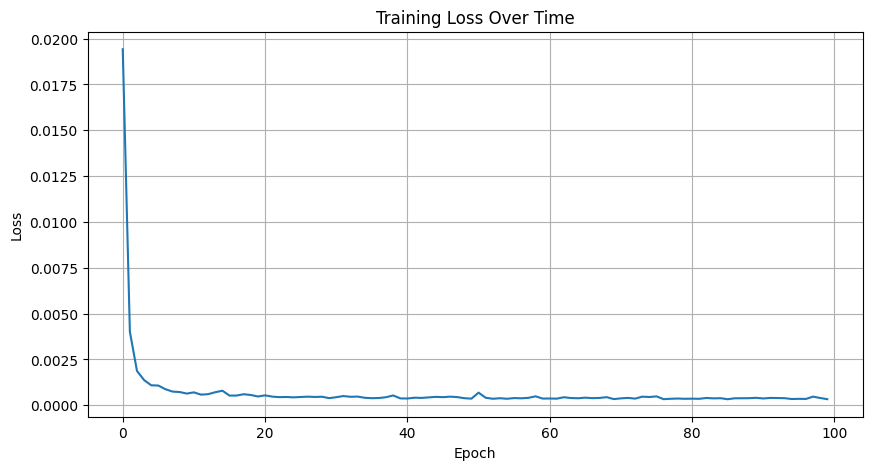

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class CustomInf:
    mitr = grad_mitr = 300
    tol = grad_tol = 1e-5

class ImplicitModelLoRA2(nn.Module):
    def __init__(self, lora_size, hidden_size, input_size, output_size):
        super().__init__()
        self.lora_size = lora_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # Main network layers
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(input_size, hidden_size, bias=False)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=False)

        # LoRA layers
        self.lora_A = nn.Linear(hidden_size, lora_size, bias=False)
        self.lora_B = nn.Linear(lora_size, hidden_size, bias=False)

        # Implicit layer
        self.implicit_layer = nn.Linear(hidden_size, hidden_size, bias=False)

        self.act = nn.Tanh()

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(0)

        h = self.fc1(x)
        h = self.act(h)

        for _ in range(CustomInf.mitr):
            h_prev = h
            lora_output = self.lora_B(self.lora_A(h))
            implicit_out = self.implicit_layer(h)
            fc2_out = self.fc2(x)

            h = self.act(implicit_out + 0.1 * lora_output + fc2_out)

            if torch.norm(h - h_prev) < CustomInf.tol * torch.norm(h):
                break

        out = self.fc3(h)
        return out

def get_oil_data():
    """Download WTI Crude Oil data"""
    oil = yf.download("CL=F", start="2010-01-01", end="2024-01-01")
    return oil['Adj Close'].fillna(method='ffill')

def prepare_sequences(data, look_back=60):
    """Prepare sequences for time series prediction"""
    values = data.reshape(-1)
    X, y = [], []

    for i in range(len(values) - look_back):
        X.append(values[i:(i + look_back)])
        y.append(values[i + look_back])

    return np.array(X), np.array(y)

def load_and_preprocess_data(data, look_back=60, train_split=0.7):
    """Load and preprocess time series data"""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = prepare_sequences(scaled_data, look_back)

    train_size = int(len(X) * train_split)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)

    return X_train, y_train, X_test, y_test, scaler

def train_model(model, X_train, y_train, device, epochs=200, lr=0.001, batch_size=32):
    """Train the implicit model with gradient clipping"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    history = []
    best_loss = float('inf')
    patience = 20
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred.squeeze(), batch_y)

            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch}")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        history.append(avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

    return history

def evaluate_predictions(model, X_test, y_test, scaler, device):
    """Evaluate model predictions"""
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()

        y_pred = y_pred.cpu().numpy()
        y_test = y_test.cpu().numpy()

        y_pred = y_pred.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        y_pred_orig = scaler.inverse_transform(y_pred)
        y_test_orig = scaler.inverse_transform(y_test)

        r2 = r2_score(y_test_orig, y_pred_orig)
        mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)

        return y_pred_orig, y_test_orig, r2, mape

def plot_results(y_train, y_test, y_pred, title="Crude Oil Price Prediction"):
    """Plot the results with predictions and actual values"""
    plt.figure(figsize=(15, 7))

    plt.plot(range(len(y_train)), y_train, label='Training Data', color='blue', alpha=0.5)

    test_start = len(y_train)
    plt.plot(range(test_start, test_start + len(y_test)), y_test, label='Actual', color='green')
    plt.plot(range(test_start, test_start + len(y_pred)), y_pred, label='Predicted', color='red')

    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)

    # Zoom into volatile region
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
    axins = zoomed_inset_axes(plt.gca(), 2.5, loc=1)

    zoom_start = test_start + int(len(y_test) * 0.4)
    zoom_end = zoom_start + 50

    axins.plot(range(zoom_start, zoom_end),
              y_test[zoom_start-test_start:zoom_end-test_start], color='green')
    axins.plot(range(zoom_start, zoom_end),
              y_pred[zoom_start-test_start:zoom_end-test_start], color='red')

    mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")
    plt.show()


def run_prediction_pipeline():
    """Complete pipeline for oil price prediction"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("Downloading oil price data...")
    oil_prices = get_oil_data()

    # Model parameters
    look_back = 60
    lora_size = 2
    hidden_size = 32
    input_size = look_back
    output_size = 1

    print("Preprocessing data...")
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data(oil_prices, look_back)
    print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")

    print("Initializing model...")
    model = ImplicitModelLoRA2(
        lora_size=lora_size,
        hidden_size=hidden_size,
        input_size=input_size,
        output_size=output_size
    )
    print(f"Model size: {sum(p.numel() for p in model.parameters())} parameters")

    print("Training model...")
    history = train_model(
        model,
        X_train,
        y_train,
        device,
        epochs=100,
        lr=0.002,
        batch_size=32
    )

    print("Evaluating model...")
    y_pred, y_test_orig, r2, mape = evaluate_predictions(model, X_test, y_test, scaler, device)

    print(f"\nModel Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")

    print("\nPlotting results...")
    y_train_orig = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
    plot_results(y_train_orig, y_test_orig, y_pred)

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model, history, (y_pred, y_test_orig, r2, mape)

def save_model(model, filename):
    """Save the trained model"""
    torch.save(model.state_dict(), filename)

def load_model(filename, model_params):
    """Load a trained model"""
    model = ImplicitModelLoRA2(**model_params)
    model.load_state_dict(torch.load(filename))
    return model

if __name__ == "__main__":
    # Run the complete pipeline
    model, history, results = run_prediction_pipeline()

    # Save the model
    save_model(model, 'oil_price_prediction_model.pth')

    # Example of loading the model
    model_params = {
        'lora_size': 2,
        'hidden_size': 32,
        'input_size': 60,
        'output_size': 1
    }
    loaded_model = load_model('oil_price_prediction_model.pth', model_params)

# Comparing with LSTMs

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_size=100, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Add an initial fully connected layer
        self.fc_in = nn.Linear(input_dim, 1)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=1,  # Input size is 1 after initial FC layer
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Project input to 1D
        x = self.fc_in(x)
        x = x.unsqueeze(-1)  # Add feature dimension

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get last output
        out = self.fc_out(out[:, -1, :])
        return out

def run_comparison_pipeline():
    """Run the complete comparison pipeline"""
    # Get data using existing function
    oil_prices = get_oil_data()

    # Use the same preprocessing as the implicit model
    look_back = 60
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data(oil_prices, look_back)

    # Store results
    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. LSTM Model
    print("\nTraining LSTM model...")
    input_dim = X_train.shape[1]  # Should be 59
    lstm_model = LSTM(input_dim=input_dim, hidden_size=100, num_layers=2, output_size=1)
    lstm_model = lstm_model.to(device)

    # Train LSTM
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

    num_epochs = 100
    batch_size = 32
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            y_pred = lstm_model(batch_X)
            loss = criterion(y_pred.squeeze(), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

    # Evaluate LSTM
    lstm_model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        lstm_preds = lstm_model(X_test).cpu().numpy()
        y_test_np = y_test.numpy()

        # Inverse transform predictions
        lstm_preds = scaler.inverse_transform(lstm_preds)
        y_test_orig = scaler.inverse_transform(y_test_np.reshape(-1, 1))

        results['LSTM'] = {
            'r2': r2_score(y_test_orig, lstm_preds),
            'mape': mean_absolute_percentage_error(y_test_orig, lstm_preds),
            'predictions': lstm_preds
        }

    # Plot comparison
    plt.figure(figsize=(15, 7))
    plt.plot(y_test_orig, label='Actual', color='black', alpha=0.7)

    colors = ['blue', 'green']
    for (model_name, metrics), color in zip(results.items(), colors):
        plt.plot(metrics['predictions'], label=f'{model_name} Predictions',
                color=color, alpha=0.6)

    plt.title("Model Comparison")
    plt.xlabel('Time Steps')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results, y_test_orig

def compare_with_implicit(implicit_results, comparison_results, y_test_orig):
    """Compare implicit model results with baseline models"""
    y_pred_implicit, _, r2_implicit, mape_implicit = implicit_results

    all_results = {
        'Implicit': {
            'r2': r2_implicit,
            'mape': mape_implicit,
            'predictions': y_pred_implicit
        },
        **comparison_results
    }

    print("\nFinal Model Comparison:")
    print("=" * 50)
    for model_name, metrics in all_results.items():
        print(f"\n{model_name} Results:")
        print(f"R² Score: {metrics['r2']:.4f}")
        print(f"MAPE: {metrics['mape']:.4f}")

    # Plot all models
    plt.figure(figsize=(15, 7))
    plt.plot(y_test_orig, label='Actual', color='black', alpha=0.7)

    colors = ['red', 'blue', 'green']
    for (model_name, metrics), color in zip(all_results.items(), colors):
        plt.plot(metrics['predictions'], label=f'{model_name} Predictions',
                color=color, alpha=0.6)

    plt.title("Complete Model Comparison")
    plt.xlabel('Time Steps')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed



Training LSTM model...
Epoch 0, Loss: 0.067732
Epoch 10, Loss: 0.001308
Epoch 20, Loss: 0.000852
Epoch 30, Loss: 0.000629
Epoch 40, Loss: 0.000547
Epoch 50, Loss: 0.000474
Epoch 60, Loss: 0.000434
Epoch 70, Loss: 0.000439
Epoch 80, Loss: 0.000389
Epoch 90, Loss: 0.000402


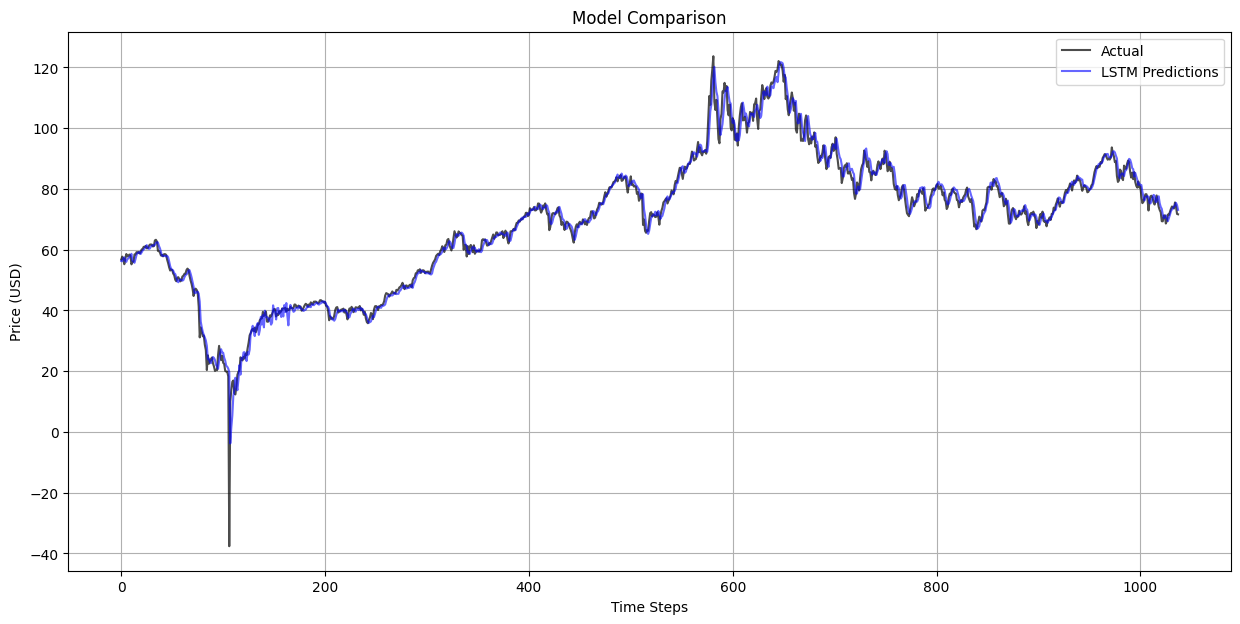


Final Model Comparison:

Implicit Results:
R² Score: 0.9821
MAPE: 0.0291

LSTM Results:
R² Score: 0.9805
MAPE: 0.0319


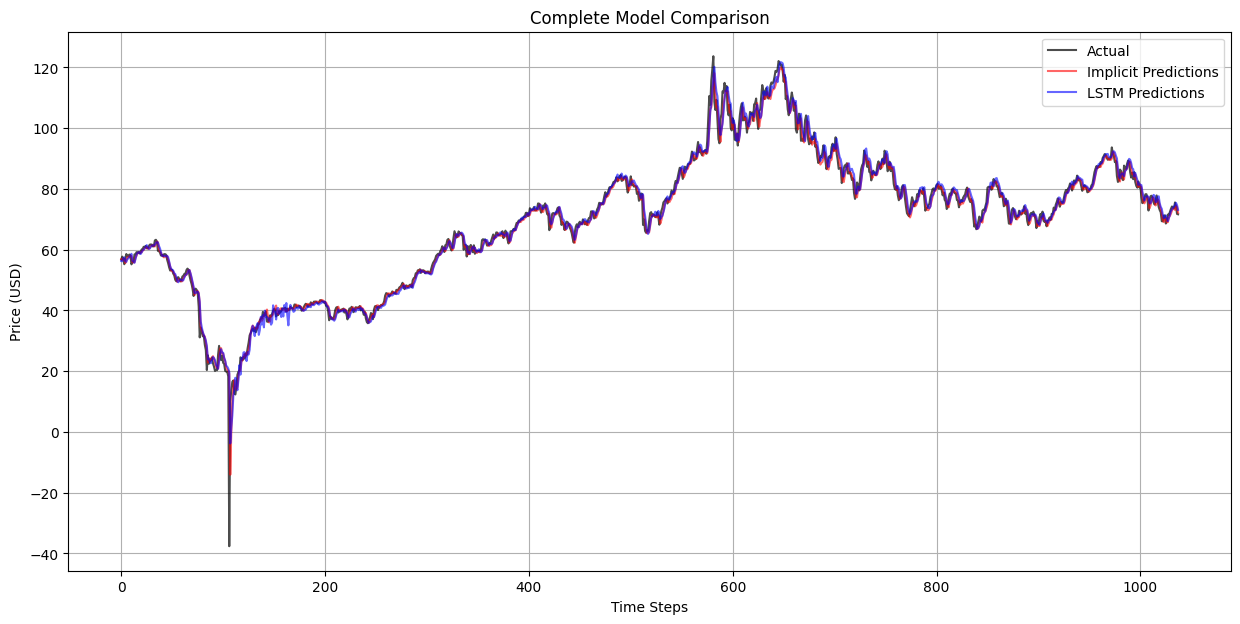

In [ ]:
# Run comparison models
comparison_results, y_test_orig = run_comparison_pipeline()

# Compare with your implicit model results
compare_with_implicit(results, comparison_results, y_test_orig)

# **Synthetic Data**



Generating synthetic financial data...


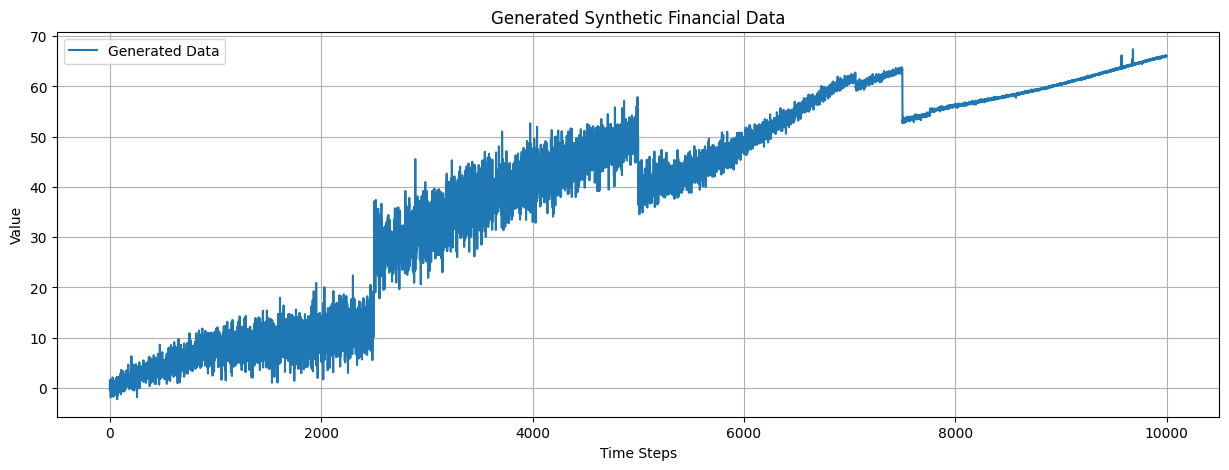

Using device: cuda

Training LSTM model...
Epoch 0, Loss: 0.291735
Epoch 10, Loss: 0.203472
Epoch 20, Loss: 0.045908
Epoch 30, Loss: 0.020049
Epoch 40, Loss: 0.009222
Epoch 50, Loss: 0.007422
Epoch 60, Loss: 0.006950
Epoch 70, Loss: 0.006881
Epoch 80, Loss: 0.006791
Epoch 90, Loss: 0.006732

Training Implicit model...
Epoch 0, Loss: 0.440749
Epoch 10, Loss: 0.044885
Epoch 20, Loss: 0.022719
Epoch 30, Loss: 0.012726
Epoch 40, Loss: 0.008258
Epoch 50, Loss: 0.007220
Epoch 60, Loss: 0.006988
Epoch 70, Loss: 0.006920
Epoch 80, Loss: 0.006859
Epoch 90, Loss: 0.006809

Results:
LSTM - R2: 0.6605, MAPE: 0.0276
Implicit - R2: 0.7986, MAPE: 0.0207


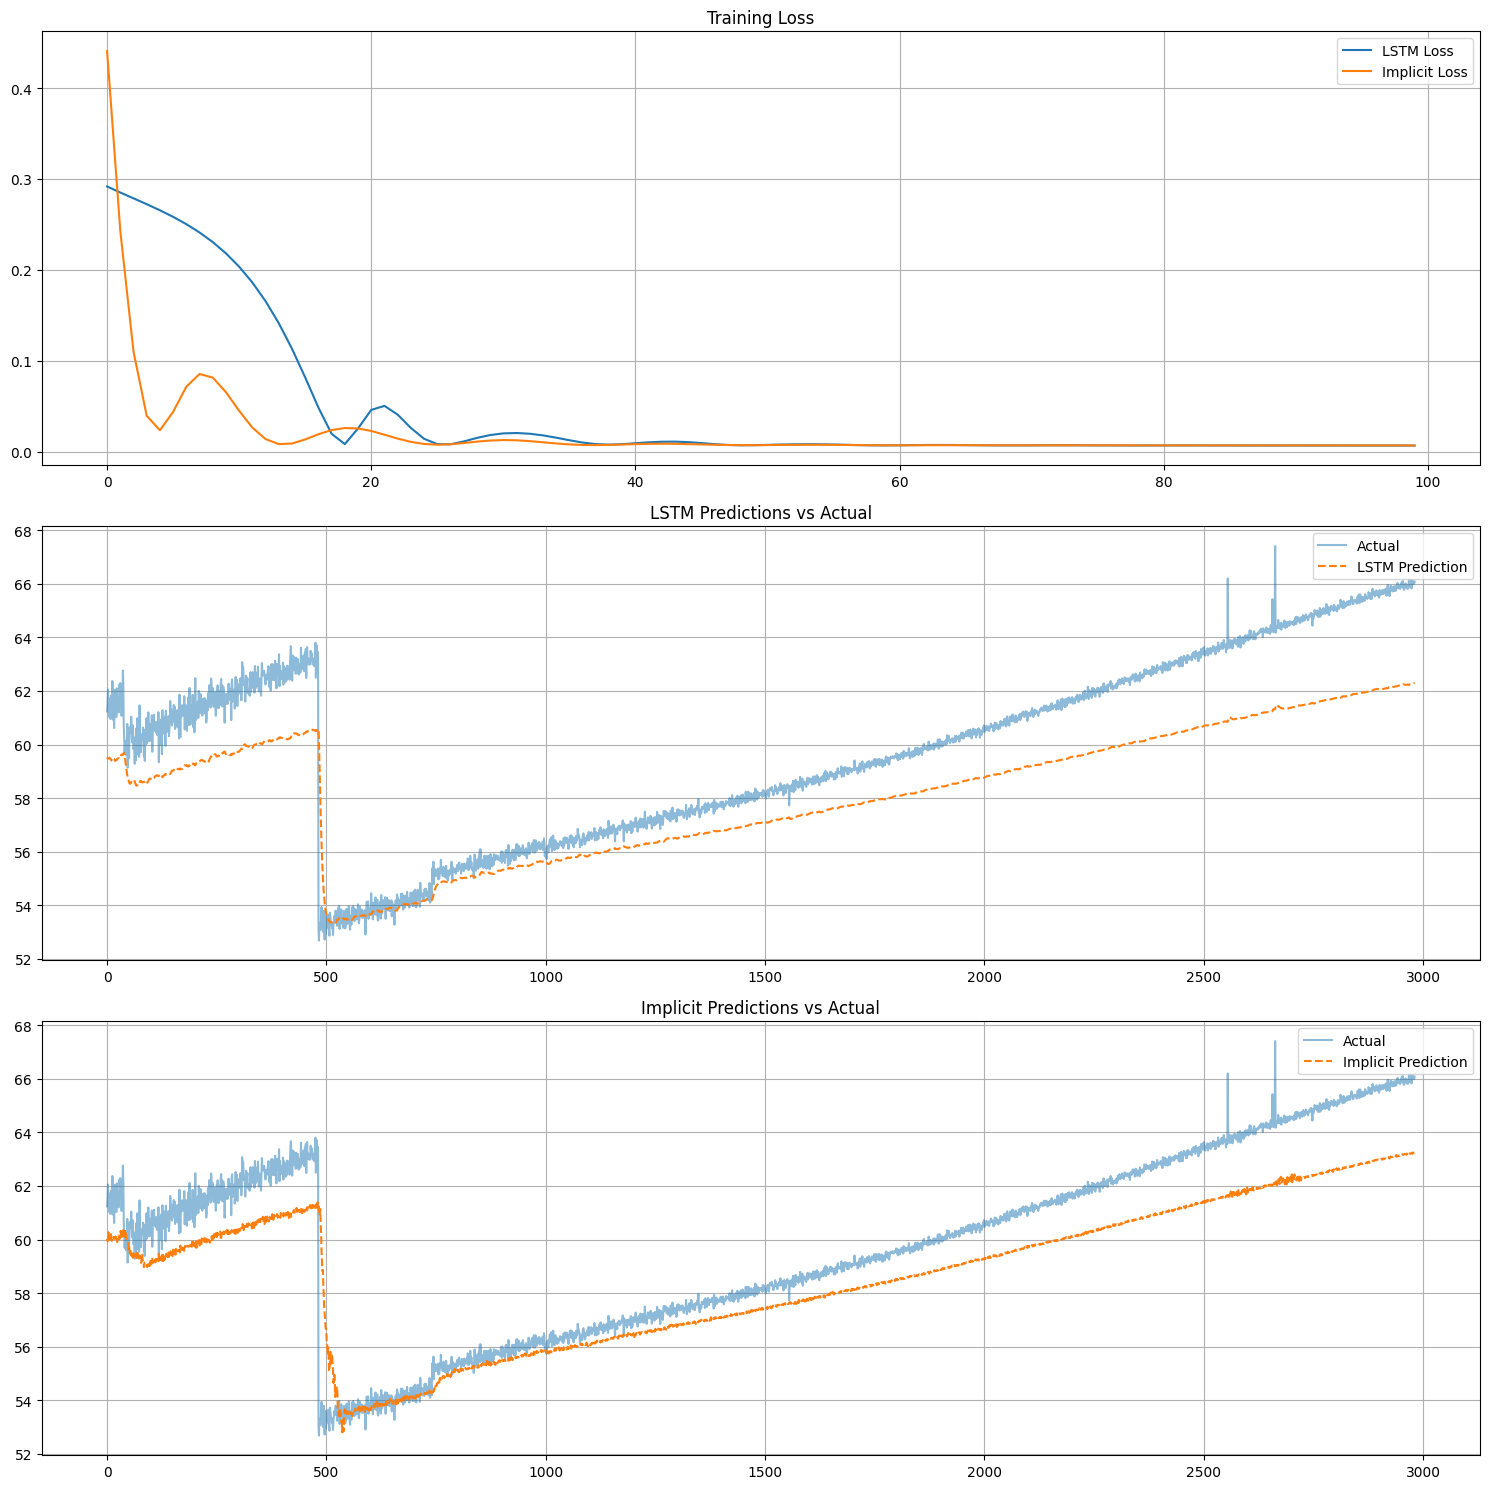

In [ ]:
# Harikrishn maharaj ni jai
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def generate_complex_financial_data(n_points=10000):

    t = np.linspace(0, 100, n_points)

    # Base trend with regime changes
    n_regimes = 4
    regimes = np.random.rand(n_regimes)  # Random regime coefficients
    regime_points = np.array_split(np.arange(n_points), n_regimes)
    trend = np.zeros(n_points)

    for i, regime_segment in enumerate(regime_points):
        trend[regime_segment] = regimes[i] * t[regime_segment]

    # Multiple overlapping cycles
    cycles = (np.sin(t/50) * 2 +
             np.sin(t/10) * 1 +
             np.sin(t/5) * 0.5)

    # Volatility clustering
    volatility = 0.1 + 0.9 * (1 + np.sin(t/20))**2
    noise = np.random.normal(0, 1, n_points) * volatility

    # Nonlinear transformations
    nonlinear = np.log1p(np.abs(t/10)) * np.sign(cycles)

    # Long-term memory component
    memory = np.zeros(n_points)
    decay = 0.99
    for i in range(1, n_points):
        memory[i] = memory[i-1] * decay + cycles[i] * (1-decay)

    # Combine components
    data = trend + cycles + nonlinear + memory + noise

    # Add sudden jumps
    jump_points = np.random.choice(n_points, 20, replace=False)
    jump_sizes = np.random.normal(0, 2, 20)
    data[jump_points] += jump_sizes

    # Add seasonal patterns
    seasonal = np.sin(2 * np.pi * t / (n_points/10)) * 0.5
    data += seasonal

    # Add trend breaks
    break_points = np.random.choice(n_points-1000, 5, replace=False)
    for bp in break_points:
        data[bp:bp+1000] += np.linspace(0, np.random.normal(0, 2), 1000)

    return data

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
def prepare_data(data, look_back=60, train_split=0.7):
    """Prepare sequences for time series prediction"""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_data[i + look_back])

    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * train_split)

    # Reshape X data for LSTM: (batch_size, sequence_length, features)
    X_train_lstm = torch.FloatTensor(X[:train_size]).view(-1, look_back, 1)
    X_test_lstm = torch.FloatTensor(X[train_size:]).view(-1, look_back, 1)

    # Reshape X data for Implicit: (batch_size, features)
    X_train_implicit = torch.FloatTensor(X[:train_size]).view(-1, look_back)
    X_test_implicit = torch.FloatTensor(X[train_size:]).view(-1, look_back)

    y_train = torch.FloatTensor(y[:train_size])
    y_test = torch.FloatTensor(y[train_size:])

    return (X_train_lstm, X_train_implicit), y_train, (X_test_lstm, X_test_implicit), y_test, scaler

class ImplicitModelLoRA2(nn.Module):
    def __init__(self, lora_size, hidden_size, input_size, output_size):
        super().__init__()
        self.lora_size = lora_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # Main network layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(input_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        # LoRA layers
        self.lora_A = nn.Linear(hidden_size, lora_size)
        self.lora_B = nn.Linear(lora_size, hidden_size)

        # Implicit layer
        self.implicit_layer = nn.Linear(hidden_size, hidden_size)
        self.act = nn.Tanh()

    def forward(self, x):
        # x shape: (batch_size, input_size)
        h = self.fc1(x)
        h = self.act(h)

        for _ in range(300):  # Max iterations
            h_prev = h
            lora_output = self.lora_B(self.lora_A(h))
            implicit_out = self.implicit_layer(h)
            fc2_out = self.fc2(x)

            h = self.act(implicit_out + 0.1 * lora_output + fc2_out)

            if torch.norm(h - h_prev) < 1e-5 * torch.norm(h):
                break

        out = self.fc3(h)
        return out

def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler,
                      epochs=100, lr=0.001, batch_size=32, device="cpu", is_lstm=False):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Select appropriate input format based on model type
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train.squeeze())
        loss.backward()
        optimizer.step()
        history.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy()
        y_test = y_test.cpu().numpy()

        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

    return history, y_pred, y_test, r2, mape

def compare_models():
    # Generate synthetic data
    print("Generating synthetic financial data...")
    data = generate_complex_financial_data()

    # Plot the generated data
    plt.figure(figsize=(15, 5))
    plt.plot(data, label='Generated Data')
    plt.title('Generated Synthetic Financial Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare data
    look_back = 60
    (X_train_lstm, X_train_implicit), y_train, (X_test_lstm, X_test_implicit), y_test, scaler = prepare_data(data, look_back)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Train and evaluate LSTM
    print("\nTraining LSTM model...")
    lstm_model = LSTM(
        input_dim=1,
        hidden_dim=64,
        num_layers=2,
        output_dim=1
    )
    lstm_history, lstm_pred, lstm_test, lstm_r2, lstm_mape = train_and_evaluate(
        lstm_model, X_train_lstm, y_train, X_test_lstm, y_test, scaler, device=device, is_lstm=True
    )

    # Train and evaluate Implicit model
    print("\nTraining Implicit model...")
    implicit_model = ImplicitModelLoRA2(
        lora_size=2,
        hidden_size=64,
        input_size=look_back,  # Changed to match input size
        output_size=1
    )
    implicit_history, implicit_pred, implicit_test, implicit_r2, implicit_mape = train_and_evaluate(
        implicit_model, X_train_implicit, y_train, X_test_implicit, y_test, scaler, device=device, is_lstm=False
    )

    # Print results
    print("\nResults:")
    print(f"LSTM - R2: {lstm_r2:.4f}, MAPE: {lstm_mape:.4f}")
    print(f"Implicit - R2: {implicit_r2:.4f}, MAPE: {implicit_mape:.4f}")

    # Plot results
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.plot(lstm_history, label='LSTM Loss')
    plt.plot(implicit_history, label='Implicit Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(lstm_test, label='Actual', alpha=0.5)
    plt.plot(lstm_pred, label='LSTM Prediction', linestyle='--')
    plt.title('LSTM Predictions vs Actual')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(implicit_test, label='Actual', alpha=0.5)
    plt.plot(implicit_pred, label='Implicit Prediction', linestyle='--')
    plt.title('Implicit Predictions vs Actual')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return data, (lstm_pred, lstm_test, lstm_r2, lstm_mape), (implicit_pred, implicit_test, implicit_r2, implicit_mape)
if __name__ == "__main__":
    data, lstm_results, implicit_results = compare_models()

Generating synthetic financial data...


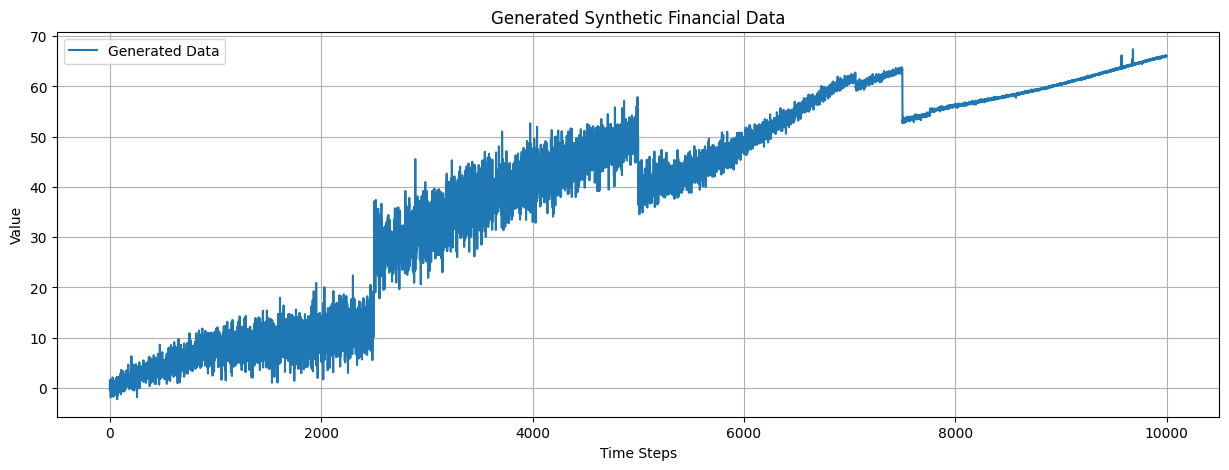

Using device: cuda

Training LSTM model...
Epoch 0, Loss: 0.291735
Epoch 10, Loss: 0.203472
Epoch 20, Loss: 0.045908
Epoch 30, Loss: 0.020049
Epoch 40, Loss: 0.009222
Epoch 50, Loss: 0.007422
Epoch 60, Loss: 0.006950
Epoch 70, Loss: 0.006881
Epoch 80, Loss: 0.006791
Epoch 90, Loss: 0.006732

Training Implicit model...
Epoch 0, Loss: 0.440749
Epoch 10, Loss: 0.044885
Epoch 20, Loss: 0.022719
Epoch 30, Loss: 0.012726
Epoch 40, Loss: 0.008258
Epoch 50, Loss: 0.007220
Epoch 60, Loss: 0.006988
Epoch 70, Loss: 0.006920
Epoch 80, Loss: 0.006859
Epoch 90, Loss: 0.006809

Average iterations during inference: 19.00

Results:
LSTM - R2: 0.6605, MAPE: 0.0276
Implicit - R2: 0.7986, MAPE: 0.0207
Implicit Model Average Iterations per Inference: 19.00

Results:
LSTM - R2: 0.6605, MAPE: 0.0276
Implicit - R2: 0.7986, MAPE: 0.0207


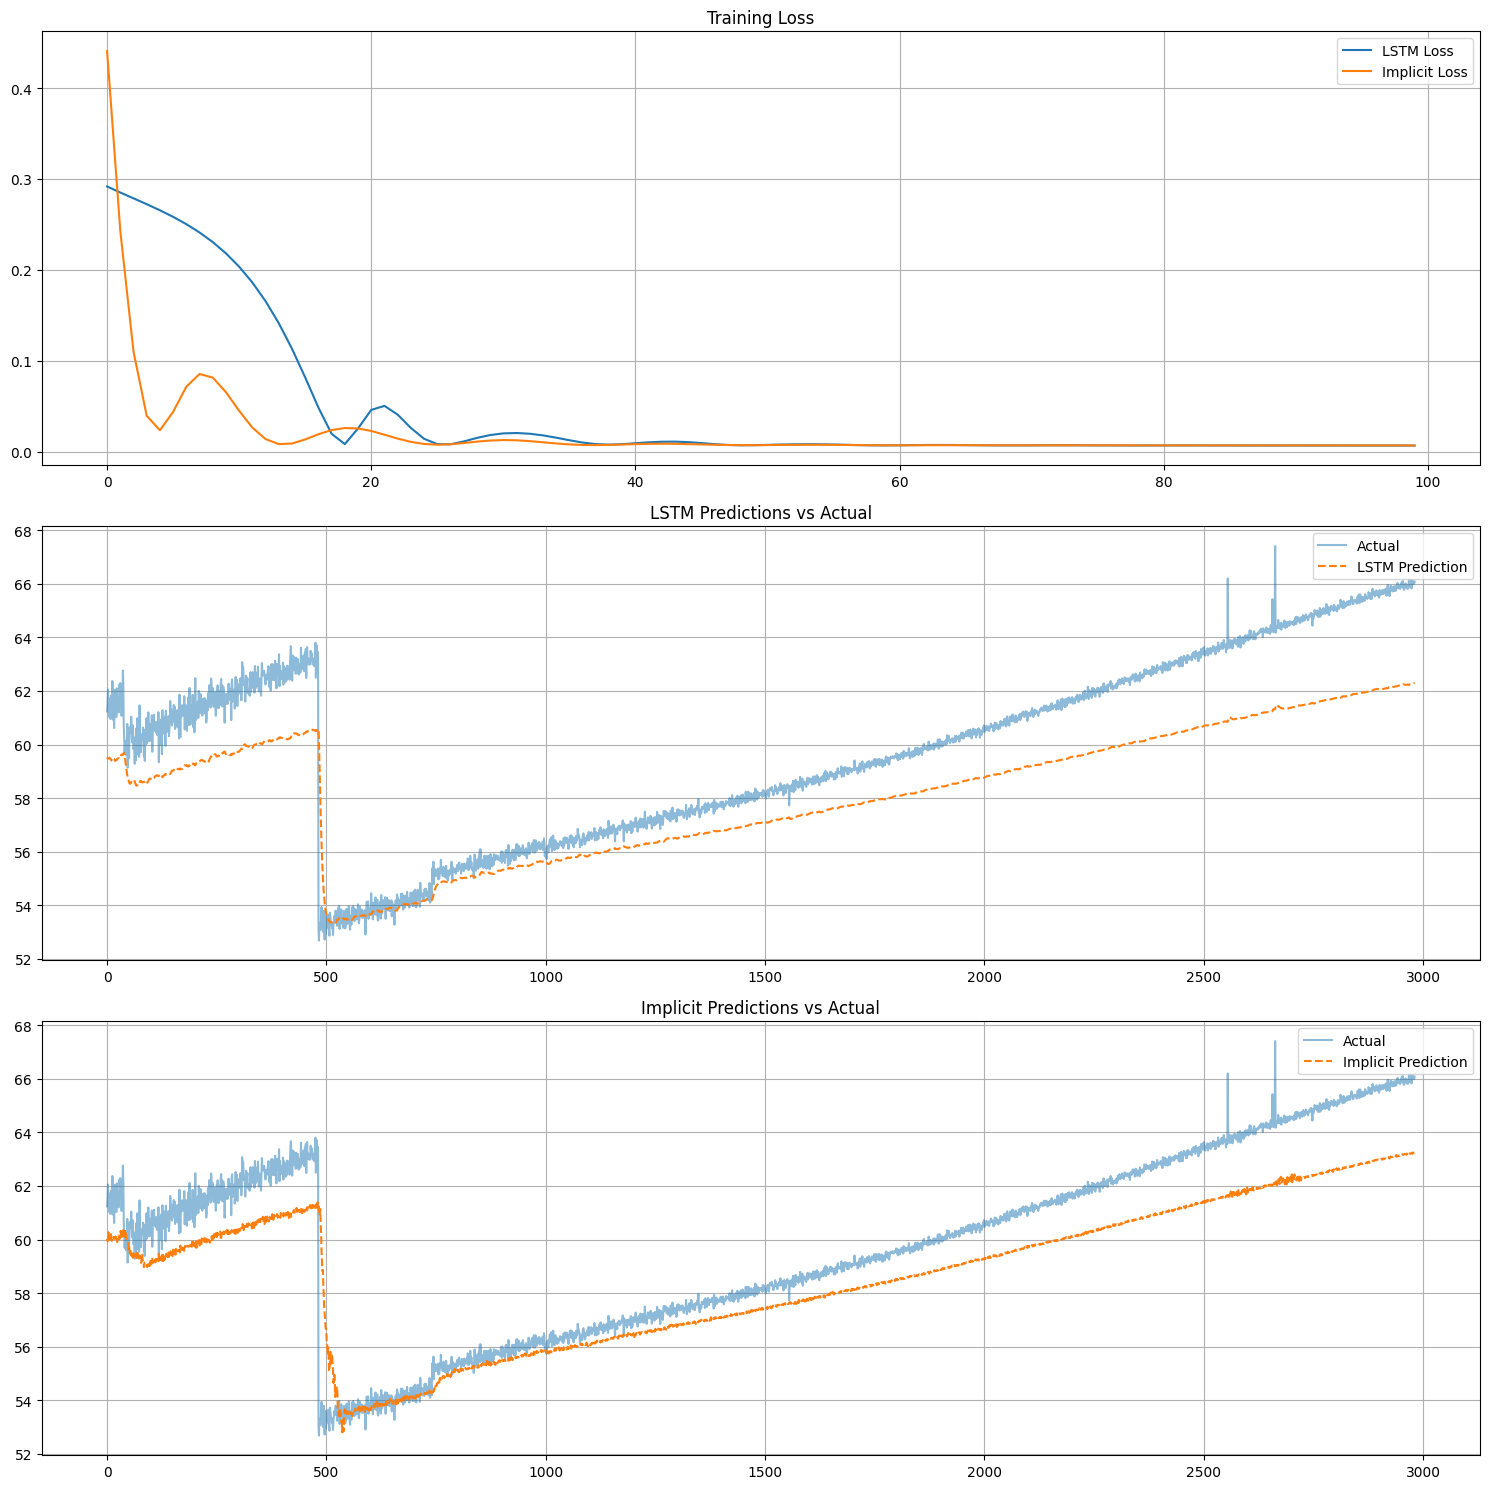

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


def generate_complex_financial_data(n_points=10000):

    t = np.linspace(0, 100, n_points)

    # Base trend with regime changes
    n_regimes = 4
    regimes = np.random.rand(n_regimes)  # Random regime coefficients
    regime_points = np.array_split(np.arange(n_points), n_regimes)
    trend = np.zeros(n_points)

    for i, regime_segment in enumerate(regime_points):
        trend[regime_segment] = regimes[i] * t[regime_segment]

    # Multiple overlapping cycles
    cycles = (np.sin(t/50) * 2 +
             np.sin(t/10) * 1 +
             np.sin(t/5) * 0.5)

    # Volatility clustering
    volatility = 0.1 + 0.9 * (1 + np.sin(t/20))**2
    noise = np.random.normal(0, 1, n_points) * volatility

    # Nonlinear transformations
    nonlinear = np.log1p(np.abs(t/10)) * np.sign(cycles)

    # Long-term memory component
    memory = np.zeros(n_points)
    decay = 0.99
    for i in range(1, n_points):
        memory[i] = memory[i-1] * decay + cycles[i] * (1-decay)

    # Combine components
    data = trend + cycles + nonlinear + memory + noise

    # Add sudden jumps
    jump_points = np.random.choice(n_points, 20, replace=False)
    jump_sizes = np.random.normal(0, 2, 20)
    data[jump_points] += jump_sizes

    # Add seasonal patterns
    seasonal = np.sin(2 * np.pi * t / (n_points/10)) * 0.5
    data += seasonal

    # Add trend breaks
    break_points = np.random.choice(n_points-1000, 5, replace=False)
    for bp in break_points:
        data[bp:bp+1000] += np.linspace(0, np.random.normal(0, 2), 1000)

    return data

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
def prepare_data(data, look_back=60, train_split=0.7):
    """Prepare sequences for time series prediction"""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_data[i + look_back])

    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * train_split)

    # Reshape X data for LSTM: (batch_size, sequence_length, features)
    X_train_lstm = torch.FloatTensor(X[:train_size]).view(-1, look_back, 1)
    X_test_lstm = torch.FloatTensor(X[train_size:]).view(-1, look_back, 1)

    # Reshape X data for Implicit: (batch_size, features)
    X_train_implicit = torch.FloatTensor(X[:train_size]).view(-1, look_back)
    X_test_implicit = torch.FloatTensor(X[train_size:]).view(-1, look_back)

    y_train = torch.FloatTensor(y[:train_size])
    y_test = torch.FloatTensor(y[train_size:])

    return (X_train_lstm, X_train_implicit), y_train, (X_test_lstm, X_test_implicit), y_test, scaler


class ImplicitModelLoRA2(nn.Module):
    def __init__(self, lora_size, hidden_size, input_size, output_size):
        super().__init__()
        self.lora_size = lora_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # Main network layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(input_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        # LoRA layers
        self.lora_A = nn.Linear(hidden_size, lora_size)
        self.lora_B = nn.Linear(lora_size, hidden_size)

        # Implicit layer
        self.implicit_layer = nn.Linear(hidden_size, hidden_size)
        self.act = nn.Tanh()

        # Iteration tracking
        self.total_iterations = 0
        self.inference_count = 0

    def forward(self, x, track_iterations=False):
        h = self.fc1(x)
        h = self.act(h)

        iterations = 0
        for _ in range(300):  # Max iterations
            h_prev = h
            lora_output = self.lora_B(self.lora_A(h))
            implicit_out = self.implicit_layer(h)
            fc2_out = self.fc2(x)

            h = self.act(implicit_out + 0.1 * lora_output + fc2_out)
            iterations += 1

            if torch.norm(h - h_prev) < 1e-5 * torch.norm(h):
                break

        if track_iterations:
            self.total_iterations += iterations
            self.inference_count += 1

        out = self.fc3(h)
        return out

    def get_average_iterations(self):
        if self.inference_count == 0:
            return 0
        return self.total_iterations / self.inference_count

    def reset_iteration_stats(self):
        self.total_iterations = 0
        self.inference_count = 0

def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler,
                      epochs=100, lr=0.001, batch_size=32, device="cpu", is_lstm=False):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    history = []

    # Training phase
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Don't track iterations during training
        if isinstance(model, ImplicitModelLoRA2):
            y_pred = model(X_train, track_iterations=False)
        else:
            y_pred = model(X_train)

        loss = criterion(y_pred.squeeze(), y_train.squeeze())
        loss.backward()
        optimizer.step()
        history.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    # Reset iteration counter before inference
    if isinstance(model, ImplicitModelLoRA2):
        model.reset_iteration_stats()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        # Track iterations during inference for implicit model
        if isinstance(model, ImplicitModelLoRA2):
            y_pred = model(X_test, track_iterations=True)
            avg_iterations = model.get_average_iterations()
            print(f"\nAverage iterations during inference: {avg_iterations:.2f}")
        else:
            y_pred = model(X_test)
            avg_iterations = None

        y_pred = y_pred.cpu().numpy()
        y_test = y_test.cpu().numpy()

        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

    return history, y_pred, y_test, r2, mape, avg_iterations

def compare_models():
    # Generate synthetic data
    print("Generating synthetic financial data...")
    data = generate_complex_financial_data()

    # Plot the generated data
    plt.figure(figsize=(15, 5))
    plt.plot(data, label='Generated Data')
    plt.title('Generated Synthetic Financial Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare data
    look_back = 60
    (X_train_lstm, X_train_implicit), y_train, (X_test_lstm, X_test_implicit), y_test, scaler = prepare_data(data, look_back)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Train and evaluate LSTM
    print("\nTraining LSTM model...")
    lstm_model = LSTM(
        input_dim=1,
        hidden_dim=64,
        num_layers=2,
        output_dim=1
    )
    lstm_history, lstm_pred, lstm_test, lstm_r2, lstm_mape, _ = train_and_evaluate(
        lstm_model, X_train_lstm, y_train, X_test_lstm, y_test, scaler, device=device, is_lstm=True
    )

    # Train and evaluate Implicit model
    print("\nTraining Implicit model...")
    implicit_model = ImplicitModelLoRA2(
        lora_size=2,
        hidden_size=64,
        input_size=look_back,
        output_size=1
    )
    implicit_history, implicit_pred, implicit_test, implicit_r2, implicit_mape, avg_iterations = train_and_evaluate(
        implicit_model, X_train_implicit, y_train, X_test_implicit, y_test, scaler, device=device, is_lstm=False
    )

    # Print results with iteration information
    print("\nResults:")
    print(f"LSTM - R2: {lstm_r2:.4f}, MAPE: {lstm_mape:.4f}")
    print(f"Implicit - R2: {implicit_r2:.4f}, MAPE: {implicit_mape:.4f}")
    print(f"Implicit Model Average Iterations per Inference: {avg_iterations:.2f}")


    # Plot results
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.plot(lstm_history, label='LSTM Loss')
    plt.plot(implicit_history, label='Implicit Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(lstm_test, label='Actual', alpha=0.5)
    plt.plot(lstm_pred, label='LSTM Prediction', linestyle='--')
    plt.title('LSTM Predictions vs Actual')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(implicit_test, label='Actual', alpha=0.5)
    plt.plot(implicit_pred, label='Implicit Prediction', linestyle='--')
    plt.title('Implicit Predictions vs Actual')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return data, (lstm_pred, lstm_test, lstm_r2, lstm_mape), (implicit_pred, implicit_test, implicit_r2, implicit_mape)
if __name__ == "__main__":
    data, lstm_results, implicit_results = compare_models()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize LSTM model
lstm_model = LSTM(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
lstm_params = count_parameters(lstm_model)
print(f"LSTM Model Parameters: {lstm_params}")

# Initialize Implicit model with LoRA
implicit_model = ImplicitModelLoRA2(
    lora_size=2,
    hidden_size=64,
    input_size=60,  # look_back window size
    output_size=1
)
implicit_params = count_parameters(implicit_model)
print(f"Implicit Model Parameters: {implicit_params}")

# Estimate inference memory usage
def estimate_inference_memory(model, avg_unfolds=1):
    total_memory = 0
    for param in model.parameters():
        param_memory = param.numel() * param.element_size()
        total_memory += param_memory
    # Adjust memory for the average number of implicit layer unfoldings
    return total_memory * avg_unfolds

# Memory usage during inference for LSTM and Implicit Model
lstm_memory = estimate_inference_memory(lstm_model, avg_unfolds=1)
implicit_memory = estimate_inference_memory(implicit_model, avg_unfolds=19)

print(f"LSTM Inference Memory: {lstm_memory / 1e6:.2f} MB")
print(f"Implicit Model Inference Memory (19 unfolds): {implicit_memory / 1e6:.2f} MB")


LSTM Model Parameters: 50497
Implicit Model Parameters: 12355
LSTM Inference Memory: 0.20 MB
Implicit Model Inference Memory (19 unfolds): 0.94 MB


In [ ]:
def count_parameters(model):
    """Count trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def detailed_parameter_count(model):
    """Print detailed parameter count for each layer"""
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.numel():,} parameters")
            total_params += param.numel()
    print(f"Total: {total_params:,} parameters")
    return total_params

def estimate_inference_memory(model, avg_unfolds=1):
    """Estimate memory usage during inference"""
    param_memory = sum(p.numel() * p.element_size() for p in model.parameters())

    # Add memory for activations
    if isinstance(model, LSTM):
        # LSTM needs memory for sequence length and hidden states
        activation_memory = (
            64  # hidden size
            * 2  # num layers
            * 4  # gates
            * 4  # bytes per float32
            * 60  # sequence length
        )
    else:
        # Implicit model needs memory for intermediate states
        activation_memory = (
            64  # hidden size
            * 4  # intermediate activations per iteration
            * 4  # bytes per float32
            * avg_unfolds  # number of iterations
        )

    total_memory = param_memory + activation_memory
    return total_memory

# Initialize models
lstm_model = LSTM(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
implicit_model = ImplicitModelLoRA2(
    lora_size=2,
    hidden_size=64,
    input_size=60,
    output_size=1
)

print("LSTM Model Parameters:")
lstm_params = detailed_parameter_count(lstm_model)

print("\nImplicit Model Parameters:")
implicit_params = detailed_parameter_count(implicit_model)

# Calculate inference memory
lstm_memory = estimate_inference_memory(lstm_model, avg_unfolds=1)
implicit_memory = estimate_inference_memory(implicit_model, avg_unfolds=19)

print(f"\nLSTM Inference Memory: {lstm_memory / 1e6:.2f} MB")
print(f"Implicit Model Inference Memory (19 unfolds): {implicit_memory / 1e6:.2f} MB")

# Print computational complexity
lstm_ops = 60 * (16640 + 32768)  # ops per timestep * sequence length
implicit_ops = 12096 * 19  # ops per iteration * iterations

print(f"\nComputational Operations:")
print(f"LSTM Operations: {lstm_ops:,}")
print(f"Implicit Model Operations: {implicit_ops:,}")
print(f"Ratio (LSTM/Implicit): {lstm_ops/implicit_ops:.2f}x")

LSTM Model Parameters:
lstm.weight_ih_l0: 256 parameters
lstm.weight_hh_l0: 16,384 parameters
lstm.bias_ih_l0: 256 parameters
lstm.bias_hh_l0: 256 parameters
lstm.weight_ih_l1: 16,384 parameters
lstm.weight_hh_l1: 16,384 parameters
lstm.bias_ih_l1: 256 parameters
lstm.bias_hh_l1: 256 parameters
fc.weight: 64 parameters
fc.bias: 1 parameters
Total: 50,497 parameters

Implicit Model Parameters:
fc1.weight: 3,840 parameters
fc1.bias: 64 parameters
fc2.weight: 3,840 parameters
fc2.bias: 64 parameters
fc3.weight: 64 parameters
fc3.bias: 1 parameters
lora_A.weight: 128 parameters
lora_A.bias: 2 parameters
lora_B.weight: 128 parameters
lora_B.bias: 64 parameters
implicit_layer.weight: 4,096 parameters
implicit_layer.bias: 64 parameters
Total: 12,355 parameters

LSTM Inference Memory: 0.32 MB
Implicit Model Inference Memory (19 unfolds): 0.07 MB

Computational Operations:
LSTM Operations: 2,964,480
Implicit Model Operations: 229,824
Ratio (LSTM/Implicit): 12.90x


In [ ]:
import numpy as np
import torch
import torch.nn as nn

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_size_bytes(model):
    """Get static model size in bytes"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return param_size + buffer_size

def estimate_lstm_inference_memory(model, batch_size=1, sequence_length=60, hidden_size=64):
    """
    Estimate LSTM memory during inference:
    - Model parameters
    - Hidden states and cell states for each layer
    - Input sequence
    - Output activations
    """
    # Static model memory
    param_memory = get_model_size_bytes(model)

    # Dynamic memory for states (hidden and cell states for each layer)
    num_layers = 2
    state_memory = (
        num_layers *  # Number of LSTM layers
        2 *          # Hidden state and cell state
        batch_size *
        hidden_size *
        4           # Float32 = 4 bytes
    )

    # Input sequence memory
    input_memory = batch_size * sequence_length * 4  # Float32

    # Output activations (one per time step)
    output_memory = batch_size * sequence_length * 4

    # Intermediate activations (gates etc.)
    gate_memory = (
        4 *         # 4 gates per layer
        num_layers *
        batch_size *
        hidden_size *
        4          # Float32
    )

    total_memory = param_memory + state_memory + input_memory + output_memory + gate_memory
    return {
        'total': total_memory,
        'parameters': param_memory,
        'states': state_memory,
        'input': input_memory,
        'output': output_memory,
        'gates': gate_memory
    }

def estimate_implicit_inference_memory(model, batch_size=1, input_size=60, hidden_size=64, avg_iterations=19):
    """
    Estimate Implicit model memory during inference:
    - Model parameters
    - Current and previous hidden states
    - Input features
    - Intermediate activations for each iteration
    """
    # Static model memory
    param_memory = get_model_size_bytes(model)

    # Input memory
    input_memory = batch_size * input_size * 4  # Float32

    # Memory for hidden states (current and previous)
    hidden_memory = 2 * batch_size * hidden_size * 4

    # Memory for LoRA intermediate results
    lora_memory = (
        batch_size *
        (2 +        # LoRA bottleneck dimension
         hidden_size) *  # LoRA output dimension
        4          # Float32
    )

    # Memory for one iteration's intermediate activations
    iteration_memory = (
        hidden_memory +    # Hidden states
        lora_memory +      # LoRA computations
        batch_size * hidden_size * 4  # Implicit layer output
    )

    # Total memory considering iterations
    total_memory = param_memory + input_memory + (iteration_memory * avg_iterations)

    return {
        'total': total_memory,
        'parameters': param_memory,
        'input': input_memory,
        'iteration': iteration_memory,
        'per_iteration': iteration_memory / avg_iterations
    }

def print_memory_analysis(lstm_memory, implicit_memory):
    """Pretty print memory analysis"""
    def bytes_to_mb(bytes_val):
        return bytes_val / (1024 * 1024)

    print("\nDetailed Memory Analysis")
    print("-" * 50)

    print("\nLSTM Memory Breakdown:")
    print(f"Parameters:     {bytes_to_mb(lstm_memory['parameters']):.3f} MB")
    print(f"States:         {bytes_to_mb(lstm_memory['states']):.3f} MB")
    print(f"Input:          {bytes_to_mb(lstm_memory['input']):.3f} MB")
    print(f"Output:         {bytes_to_mb(lstm_memory['output']):.3f} MB")
    print(f"Gates:          {bytes_to_mb(lstm_memory['gates']):.3f} MB")
    print(f"Total:          {bytes_to_mb(lstm_memory['total']):.3f} MB")

    print("\nImplicit Model Memory Breakdown:")
    print(f"Parameters:     {bytes_to_mb(implicit_memory['parameters']):.3f} MB")
    print(f"Input:          {bytes_to_mb(implicit_memory['input']):.3f} MB")
    print(f"Per Iteration:  {bytes_to_mb(implicit_memory['per_iteration']):.3f} MB")
    print(f"Total:          {bytes_to_mb(implicit_memory['total']):.3f} MB")

    print("\nComparison:")
    ratio = implicit_memory['total'] / lstm_memory['total']
    print(f"Implicit/LSTM Memory Ratio: {ratio:.2f}x")

def compare_inference_memory(batch_size=1, sequence_length=60):
    # Initialize models
    lstm_model = LSTM(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
    implicit_model = ImplicitModelLoRA2(
        lora_size=2,
        hidden_size=64,
        input_size=60,
        output_size=1
    )

    # Parameter counts
    lstm_params = count_parameters(lstm_model)
    implicit_params = count_parameters(implicit_model)
    print(f"LSTM Parameters: {lstm_params:,}")
    print(f"Implicit Parameters: {implicit_params:,}")

    # Memory analysis
    lstm_memory = estimate_lstm_inference_memory(
        lstm_model,
        batch_size=batch_size,
        sequence_length=sequence_length
    )

    implicit_memory = estimate_implicit_inference_memory(
        implicit_model,
        batch_size=batch_size,
        input_size=sequence_length,
        avg_iterations=19
    )

    print_memory_analysis(lstm_memory, implicit_memory)

    return lstm_memory, implicit_memory

# Run comparison
if __name__ == "__main__":
    lstm_mem, implicit_mem = compare_inference_memory(batch_size=1)

LSTM Parameters: 50,497
Implicit Parameters: 12,355

Detailed Memory Analysis
--------------------------------------------------

LSTM Memory Breakdown:
Parameters:     0.193 MB
States:         0.001 MB
Input:          0.000 MB
Output:         0.000 MB
Gates:          0.002 MB
Total:          0.196 MB

Implicit Model Memory Breakdown:
Parameters:     0.047 MB
Input:          0.000 MB
Per Iteration:  0.000 MB
Total:          0.066 MB

Comparison:
Implicit/LSTM Memory Ratio: 0.34x
